In [1]:
import torch
import numpy as np


import util, tr_util
from zNetwork.model_global import HybridNetworkGlobal
from Dimploma.ppo_parallel_custom import test_random
from Dimploma.utils.graph_provider import GraphProvider

In [2]:
%load_ext autoreload
%autoreload 2

In [27]:
default_path = 'results/min_tree_ppo/node/'
# default_path = 'results/min_tree_ppo/node_cuda/'
# agent_path = '250220_15#n10_e36_pos3'
agent_path = '250313_22#n10_e33_new_net_g13'
testing_path = f'{default_path}{agent_path}'

In [28]:
tr_util.load_desc(testing_path)


Training comment:
Experimenting with a new network structure
fixed graph 12 bad to be bad in a way that i wanted

Trying out training with:

Training
Iterations: 1000
Epochs: 10
Batch size: 64
Steps amount: 18
On device: cpu
with early stopping

Graphs:
Loaded graph from graphs/graph13_n10_e33_custom_bad2fix.pt
Node amount: 10
Edge amount: 33
Node features: 2
With indexes in nodes


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.001
Gae_lambda: 0.95
Learning rate: 0.00025



In [29]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = 33
node_features = 2  # (index, {0,1} selected or not)
iteration_amount = 1000
position = False
remove_index = False
if position:
    node_features += 2
if remove_index:
    node_features -= 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph_provider = GraphProvider(fixed_graph=None, device=device, nodes=node_amount, edges=edge_amount, position=position)


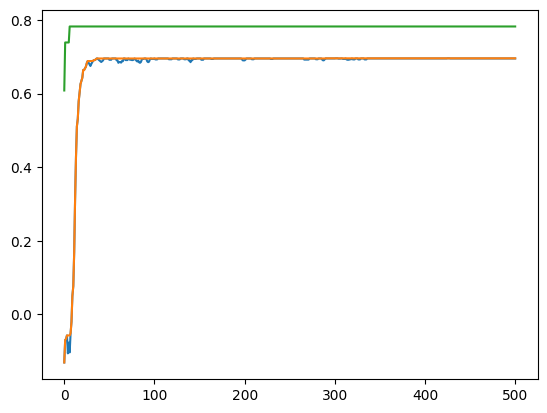

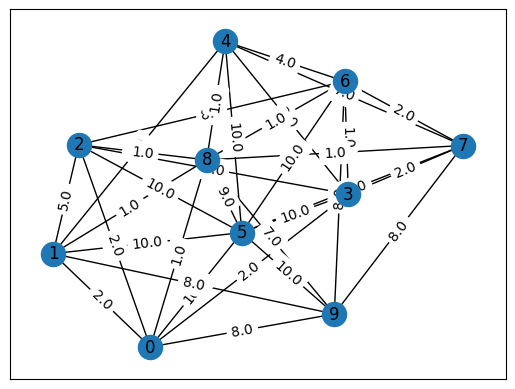

Loading model from results/min_tree_ppo/node/250313_22#n10_e33_new_net_g13/models/iter_999_last.pt


In [30]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(testing_path, iteration_amount, graph_provider, HybridNetworkGlobal(node_features, node_amount), device)

In [31]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}, Min: {objs_test.min()}, Max: {objs_test.max()}')
# print(f'Mean: {objs_test.mean():.2f}')
# print(f'Min: {objs_test.min()}')
# print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}, Min: {objs_test_r.min()}, Max: {objs_test_r.max()}')
# print(f'Mean: {objs_test_r.mean():.2f}')
# print(f'Min: {objs_test_r.min()}')
# print(f'Max: {objs_test_r.max()}')
print(f'Optimal: {test_env.calculate_min_span_tree()}')

Objs
Mean: 30.00, Min: 30.0, Max: 30.0
Random
Mean: 47.44, Min: 26.0, Max: 70.0
Optimal: 23.0


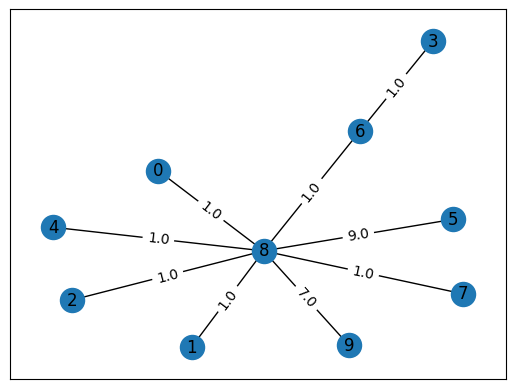

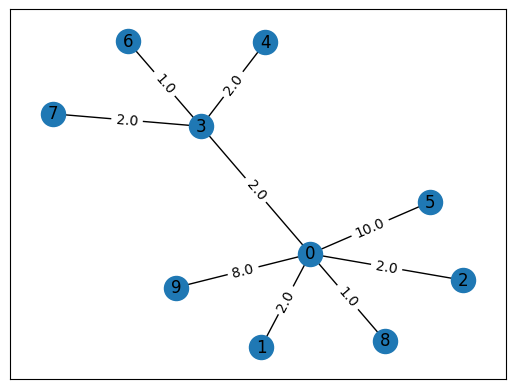

(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6956521739130435],
 [3, 0, 0, 2, 0, 9, 3, 7, 0, 8, 0, 1, 0, 5, 3, 4, 3, 6])

In [32]:
_, a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [33]:
torch.cat([util.get_node_sums(loaded_graph).T, util.get_out_edges(loaded_graph).T], dim=1).T

tensor([[3.0000, 8.0000, 0.0000, 2.0000, 7.0000, 4.0000, 1.0000, 6.0000, 9.0000,
         5.0000],
        [1.9000, 2.2000, 2.5000, 2.8000, 3.0000, 3.1000, 3.3000, 3.4000, 4.9000,
         8.9000],
        [0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 7.0000, 9.0000, 6.0000, 8.0000,
         5.0000],
        [6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 7.0000, 8.0000,
         9.0000]])

In [26]:
util.get_node_sums_norm(loaded_graph)

tensor([[8.0000, 3.0000, 0.0000, 6.0000, 7.0000, 9.0000, 2.0000, 4.0000, 1.0000,
         5.0000],
        [0.1000, 0.1833, 0.3167, 0.4000, 0.4167, 0.4333, 0.4667, 0.5167, 0.5500,
         0.8111]])

In [ ]:
torch.cat([loaded_graph.edge_index.T, loaded_graph.edge_attr], dim=1)

In [ ]:
loaded_graph.x[:, 1:]